# Data Analysis, Prediction and Healthcare Impact

This Notebook is for analysis of the fire and AQI data extracted for Del Rio Texas and comparing certain results. The results/visualizations included are:
1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

Also, we are deploying a Predictive Model to predict the Smoke Estimate up to 2049 in the future. I have used Time Series forecasting model here: ARIMA for the prediction.

## Import Libraries

In [90]:
# Import Libraries
import pandas as  pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

## Fires Data

Import the Wildfire data we extracted for Del Rio

In [18]:
# Get Wildfires data extracted using USGS extraction
del_rio_fires_df = pd.read_parquet('del_rio_fires_df.pqt')
del_rio_fires_df.head()

OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
0     14306             14306           Wildfire       1963   
1     14305             14305           Wildfire       1963   
2     14341             14341           Wildfire       1963   
3     14308             14308           Wildfire       1963   
4     14324             14324           Wildfire       1963   

   Fire_Polygon_Tier Fire_Attribute_Tiers    GIS_Acres  GIS_Hectares  \
0                  1         1 (1), 3 (1)  4995.253626   2021.507422   
1                  1         1 (3), 3 (3)  4995.910129   2021.773099   
2                  1         1 (2), 3 (2)   647.246513    261.931371   
3                  1         1 (1), 3 (2)  4293.410613   1737.481631   
4                  1         1 (1), 3 (3)  1552.699889    628.355352   

                                     Source_Datasets  \
0  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
1  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
2  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
3  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
4  Comb_National_NIFC_Interagency_Fire_Perimeter_...   

                   Listed_Fire_Types  ...  \
0                       Wildfire (2)  ...   
1                       Wildfire (6)  ...   
2                       Wildfire (4)  ...   
3  Wildfire (1), Likely Wildfire (2)  ...   
4  Wildfire (3), Likely Wildfire (1)  ...   

                          Overlap_Within_1_or_2_Flag Circleness_Scale  \
0  Caution, this Wildfire in 1963 overlaps with a...         0.994707   
1                                               None         0.994948   
2                                               None         0.272200   
3                                               None         0.344648   
4                                               None         0.709395   

  Circle_Flag Exclude_From_Summary_Rasters  Shape_Length    Shape_Area  \
0         1.0                          Yes  15980.673439  2.021507e+07   
1         1.0                          Yes  15979.785579  2.021773e+07   
2         NaN                           No  10996.509615  2.619314e+06   
3         NaN                           No  25169.664017  1.737482e+07   
4         NaN                           No  10550.269932  6.283554e+06   

    fire_lat    fire_lon distance_from_del_rio smoke_estimate  
0  36.475031 -106.702400            594.570587      84.014476  
1  35.678581 -106.479715            543.334644      91.949044  
2  43.526843 -103.471741            986.598492       6.560384  
3  43.154410 -113.233561           1171.237153      36.657056  
4  34.728314 -119.946244           1175.406549      13.209897  

[5 rows x 34 columns]

In [20]:
# Describe the data
del_rio_fires_df.describe()

OBJECTID  USGS_Assigned_ID     Fire_Year  Fire_Polygon_Tier  \
count   70861.000000      70861.000000  70861.000000       70861.000000   
mean    72207.062799      72207.062799   2003.644628           2.884196   
std     32845.279641      32845.279641     13.724469           2.452673   
min     14304.000000      14304.000000   1963.000000           1.000000   
25%     44065.000000      44065.000000   1996.000000           1.000000   
50%     73113.000000      73113.000000   2008.000000           1.000000   
75%    100792.000000     100792.000000   2014.000000           6.000000   
max    135060.000000     135060.000000   2020.000000           8.000000   

          GIS_Acres  GIS_Hectares  Circleness_Scale  Circle_Flag  \
count  7.086100e+04  7.086100e+04      70861.000000       5440.0   
mean   1.788710e+03  7.238653e+02          0.471217          1.0   
std    1.263020e+04  5.111262e+03          0.261127          0.0   
min    6.558795e-07  2.654250e-07          0.000051          1.0   
25%    1.280371e+01  5.181479e+00          0.262550          1.0   
50%    1.179990e+02  4.775249e+01          0.435511          1.0   
75%    9.972989e+02  4.035925e+02          0.647025          1.0   
max    1.566273e+06  6.338483e+05          0.999917          1.0   

       Shape_Length    Shape_Area      fire_lat      fire_lon  \
count  7.086100e+04  7.086100e+04  70861.000000  70861.000000   
mean   1.188840e+04  7.238653e+06     36.498640   -102.458844   
std    7.499986e+04  5.111262e+07      4.669699     12.727054   
min    1.212677e+00  2.654250e-03     24.671056   -121.001852   
25%    1.133512e+03  5.181479e+04     33.538415   -113.798435   
50%    3.933408e+03  4.775249e+05     36.015440   -105.456179   
75%    1.246434e+04  4.035925e+06     39.680282    -91.351740   
max    1.757948e+07  6.338483e+09     47.462191    -80.183831   

       distance_from_del_rio  smoke_estimate  
count           70861.000000    7.086100e+04  
mean              910.914087    2.646780e+01  
std               273.895628    2.720438e+02  
min                28.803066    6.925918e-09  
25%               698.491282    1.468207e-01  
50%               977.185558    1.333327e+00  
75%              1148.241019    1.118261e+01  
max              1249.996926    3.915455e+04

## Create a Smoke Estimate

We will be creating a smoke estimate based on the metrics we extracted from the fire data and create a metric which will define the impact of the fire on the city.
I have created this metric based on the proportionality of the metrics.

**Smoke Estimate:**
Smoke Estimate = (Area burned in Acres/Distance from the city)*10

Smoke estimate is directly proportional to the area burnt i.e. it will have a higher impact on the city if the area is more and is inversely proportional to the distance from the city i.e. it will have higher impact for a shorter distance from the city. 10 is used to normalize the values.

In [21]:
# Create a smoke estimate column using formula
del_rio_fires_df['smoke_estimate'] = (del_rio_fires_df['GIS_Acres']/del_rio_fires_df['distance_from_del_rio'])*10
del_rio_fires_df.head()

OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
0     14306             14306           Wildfire       1963   
1     14305             14305           Wildfire       1963   
2     14341             14341           Wildfire       1963   
3     14308             14308           Wildfire       1963   
4     14324             14324           Wildfire       1963   

   Fire_Polygon_Tier Fire_Attribute_Tiers    GIS_Acres  GIS_Hectares  \
0                  1         1 (1), 3 (1)  4995.253626   2021.507422   
1                  1         1 (3), 3 (3)  4995.910129   2021.773099   
2                  1         1 (2), 3 (2)   647.246513    261.931371   
3                  1         1 (1), 3 (2)  4293.410613   1737.481631   
4                  1         1 (1), 3 (3)  1552.699889    628.355352   

                                     Source_Datasets  \
0  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
1  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
2  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
3  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
4  Comb_National_NIFC_Interagency_Fire_Perimeter_...   

                   Listed_Fire_Types  ...  \
0                       Wildfire (2)  ...   
1                       Wildfire (6)  ...   
2                       Wildfire (4)  ...   
3  Wildfire (1), Likely Wildfire (2)  ...   
4  Wildfire (3), Likely Wildfire (1)  ...   

                          Overlap_Within_1_or_2_Flag Circleness_Scale  \
0  Caution, this Wildfire in 1963 overlaps with a...         0.994707   
1                                               None         0.994948   
2                                               None         0.272200   
3                                               None         0.344648   
4                                               None         0.709395   

  Circle_Flag Exclude_From_Summary_Rasters  Shape_Length    Shape_Area  \
0         1.0                          Yes  15980.673439  2.021507e+07   
1         1.0                          Yes  15979.785579  2.021773e+07   
2         NaN                           No  10996.509615  2.619314e+06   
3         NaN                           No  25169.664017  1.737482e+07   
4         NaN                           No  10550.269932  6.283554e+06   

    fire_lat    fire_lon distance_from_del_rio smoke_estimate  
0  36.475031 -106.702400            594.570587      84.014476  
1  35.678581 -106.479715            543.334644      91.949044  
2  43.526843 -103.471741            986.598492       6.560384  
3  43.154410 -113.233561           1171.237153      36.657056  
4  34.728314 -119.946244           1175.406549      13.209897  

[5 rows x 34 columns]

The smoke estimate is then aggregated Annually where I have taken **Average/Mean** of the Daily Smoke Estimate to get an Annual Smoke Estimate. I have also tried the sum to see the variation but then finalized the Average.

In [22]:
# Aggregate the data annually
del_rio_fires_df_annual =  del_rio_fires_df.groupby('Fire_Year').agg(sum_smoke_estimate=('smoke_estimate','sum'), avg_smoke_estimate=('smoke_estimate','mean')).reset_index()
del_rio_fires_df_annual.head()

Fire_Year  sum_smoke_estimate  avg_smoke_estimate
0       1963          800.822591            3.364801
1       1964         2359.505274           12.418449
2       1965          591.580867            2.830530
3       1966         4312.369918           16.459427
4       1967         2520.693706            9.067244

#### Line Chart for sum of Smoke estimate across Years of Fire

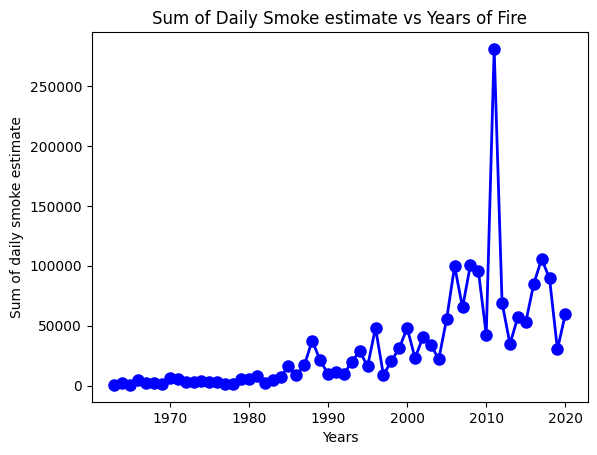

In [23]:
# Plot Sum of Daily Smoke estimates vs Years of fire
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['sum_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Sum of Daily Smoke estimate vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('Sum of daily smoke estimate')
plt.show()

#### Line Chart for Average of Smoke estimate across Years of Fire

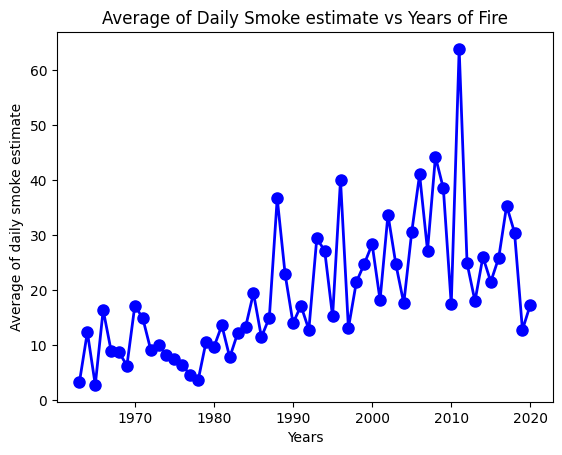

In [24]:
# Plot Average of Smoke estimate vs Years of Fire
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['avg_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Average of Daily Smoke estimate vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('Average of daily smoke estimate')
plt.show()

## AQI Data

Import AQI data extracted for Del Rio Texas

In [25]:
# Get the AQI data
final_aqi_df = pd.read_csv('final_aqi.csv',index_col=False)
final_aqi_df

Unnamed: 0  date_local pollutant_standard   aqi
0               0  1988-03-02                NaN  20.0
1               1  1988-03-05                NaN  18.0
2               2  1988-03-09                NaN  23.0
3               3  1988-03-16                NaN  46.0
4               4  1988-03-19                NaN  11.0
...           ...         ...                ...   ...
53553        2530  2022-12-19                NaN  14.0
53554        2531  2022-12-22                NaN  20.0
53555        2532  2022-12-25                NaN  11.0
53556        2533  2022-12-28                NaN  16.0
53557        2534  2022-12-31                NaN   6.0

[53558 rows x 4 columns]

## Annual AQI calculation

Annual AQI is calculated by taking max of AQI for each day based on Pollutant standards and then taking the Average of the top 30 AQI values for a year. This will ensure we calculate the right annual AQI

In [26]:
# Aggregate final AQI based on top 30 formula
aqi = final_aqi_df.groupby('date_local')['aqi'].max().reset_index()
aqi['year'] = pd.to_datetime(aqi['date_local']).dt.year
aqi_per_year = aqi.groupby('year')['aqi'].apply(lambda group: group.nlargest(30).mean()).reset_index()
aqi_per_year.head()

year        aqi
0  1988  39.300000
1  1989  42.133333
2  1990  43.333333
3  1991  38.333333
4  1992  32.966667

#### Line Chart for Annual AQI across Years of Fire for Del Rio Texas

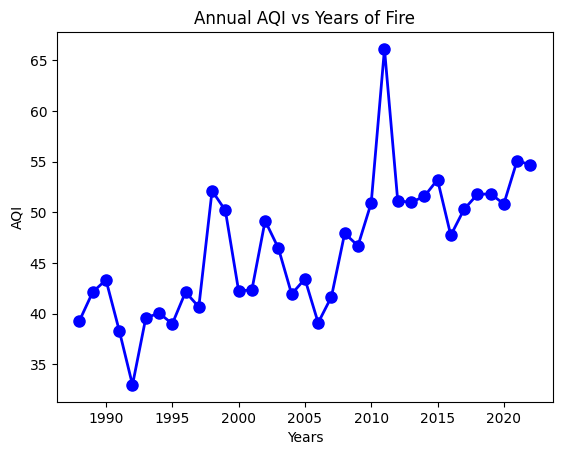

In [27]:
# Plot Annual AQI vs Years of Fire for Del Rio Texas
plt.plot(aqi_per_year['year'],
         aqi_per_year['aqi'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Annual AQI vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('AQI')
plt.show()

# Visualizations

## 1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

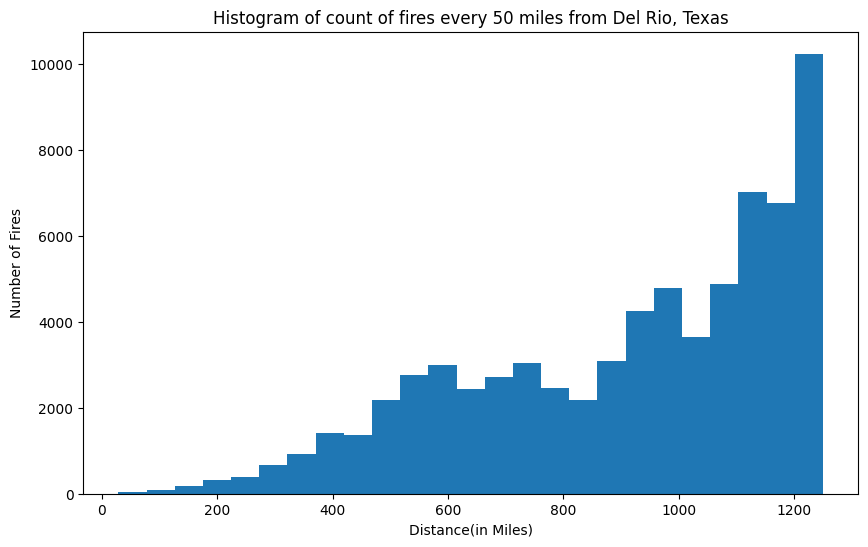

In [28]:
# Plot histogram for the number of fires across Distance
plt.figure(figsize=(10, 6)) 

bin_width = 50
data_range = max(del_rio_fires_df['distance_from_del_rio']) - min(del_rio_fires_df['distance_from_del_rio'])
num_bins = int(data_range / bin_width)

plt.hist(del_rio_fires_df['distance_from_del_rio'],bins=25)
# Customize the chart
plt.title('Histogram of count of fires every 50 miles from Del Rio, Texas')
plt.xlabel('Distance(in Miles)')
plt.ylabel('Number of Fires')

# Display the chart
plt.show()

## 2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

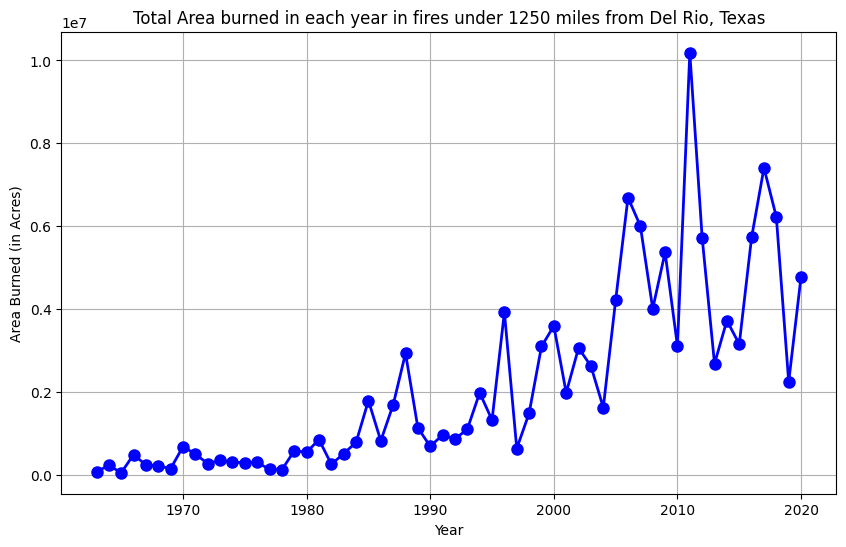

In [29]:
# Plot Area burned across time (year)
area_burned = del_rio_fires_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(10, 6)) 

# Create a line chart for the second line
plt.plot(area_burned['Fire_Year'], area_burned['GIS_Acres'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Total Area burned in each year in fires under 1250 miles from Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Area Burned (in Acres)')

# Display the chart
plt.grid(True)
plt.show()

## 3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

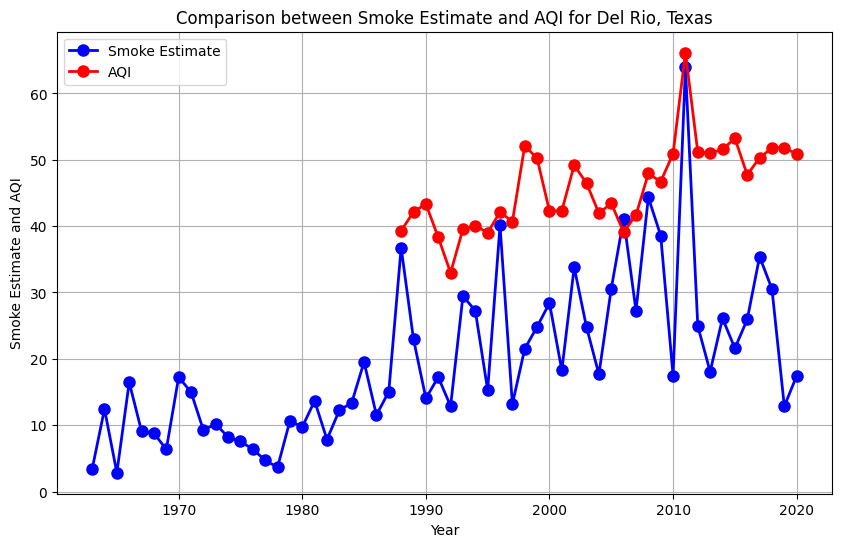

In [30]:
# Plot Smoke Estimates and AQI 
smoke_aqi = pd.merge(del_rio_fires_df_annual,aqi_per_year,how="left",left_on="Fire_Year",right_on="year")

plt.figure(figsize=(10, 6)) 
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['aqi'], label='AQI', marker='o', color='r', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Comparison between Smoke Estimate and AQI for Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate and AQI')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()

# Prediction

We will be predicting the smoke estimates calculated based on current data into future uoto 2049. I am using ARIMA time series model for the prediction and displaying the final predictions using the model

## Model parameters

In [31]:
# Load your data
data = pd.Series(del_rio_fires_df_annual['avg_smoke_estimate'])  

model = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True,
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

# Get the best order (p, d, q) determined by auto_arima
best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=438.210, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=461.094, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=445.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=430.000, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=457.072, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=433.003, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=432.499, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=436.327, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=427.564, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=429.941, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=429.137, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=441.703, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=432.753, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.472 seconds
Best (p, d, q) order: (0, 1, 1)


## Fitting the model and tweaking parameters to get best  results

In [32]:
# Fit ARIMA model
model = ARIMA(data, order=(4,2,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=28)
predictions_data = pd.DataFrame({'Year': range(2021, 2049), 'Predictions': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC : 428.72015890632406 BIC : 444.92297243220526


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Final Prediction Visualization

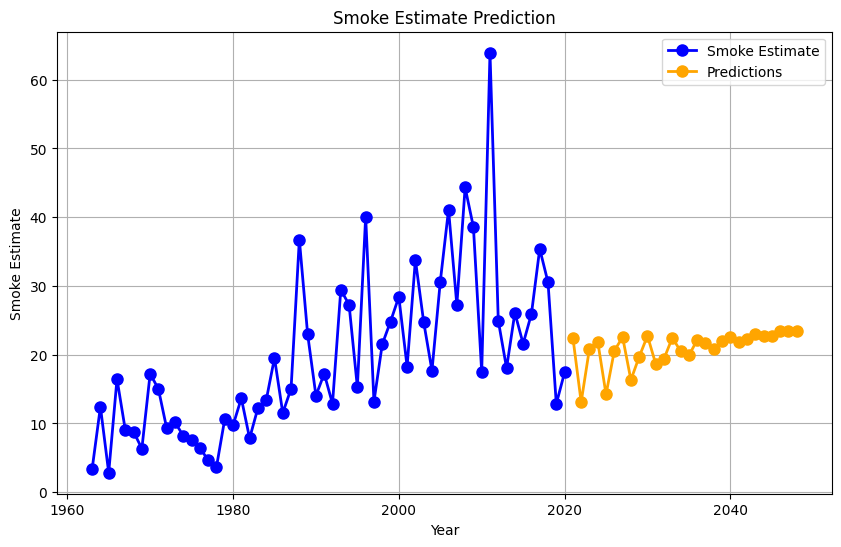

In [33]:
# Plot ARIMA predictions for next 25 years
plt.figure(figsize=(10, 6)) 
plt.plot(del_rio_fires_df_annual['Fire_Year'], del_rio_fires_df_annual['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(predictions_data['Year'], predictions_data['Predictions'], label='Predictions', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Smoke Estimate Prediction')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()

# Healthcare effect in Val Verde

Here we will look at the Impact of Smoke Estimate on Healthcare at Del Rio/ Val Verde county.
1. Mortality Analysis:
The analysis of overall mortality rates serves as a fundamental component in gauging the healthcare impact of wildfires. We extracted data with number of deaths in Val Verde County over the years and compared it with the Smoke Estimates. We saw whether there is a discernible correlation between wildfires and mortality rates, providing crucial insights for healthcare planning and intervention


2. 
Cancer Deaths Analysis:
This analysis acknowledges the potential long-term consequences of smoke exposure, specifically on cancer incidences and mortalities. By analyzing the patterns and trends in cancer deaths over the years, we seek to ascertain the extent to which wildfires might be implicated in cancer-related health outcomes within the Del Rio community. This is for deaths due to all cancers which include more than 60% deaths by Lung Canc


3. r.
Fetal/Infant Deaths Analysis:
The analysis of fetal and infant deaths introduces a critical dimension to the methodology, examining the vulnerability of the youngest members of the population to wildfire-induced smoke. The goal here was to analyze whether there is a correlation between smoke estimates and adverse outcomes in fetal and infant health. This analysis is particularly sensitive, shedding light on potential risks that may necessitate targeted healthcare interventions.


In [147]:
# Get the Deaths by Race data in texas
deaths_race_df = pd.read_excel('deaths_by_race.xlsx')
# deaths_race_df['Year']=deaths_race_df['Year'].astype('float')
deaths_race_df.head()

Year  All Races Total Deaths - Texas  All Races Total Deaths  \
0  2015                          189166                302.6656   
1  2014                          183303                293.2848   
2  2013                          178501                285.6016   
3  2012                          173935                278.2960   
4  2011                          167997                268.7952   

   All Races Male Deaths  All Races Female Deaths  White Total Deaths  \
0                  97822                    91344              121778   
1                  95035                    88268              119355   
2                  91945                    86556              117110   
3                  89332                    84603              115089   
4                  85728                    82269              111995   

   White Male Deaths  White Female Deaths  Black Total Deaths  \
0              61875                59903               22725   
1              60880                58475               21880   
2              59238                57872               21141   
3              58194                56895               20560   
4              56096                55899               20160   

   Black Male Deaths  Black Female Deaths Hispanic* Total Deaths  \
0              11713                11012                  39508   
1              11164                10716                  37629   
2              10863                10278                  36223   
3              10460                10100                  34756   
4              10056                10104                  32638   

  Hispanic* Male Deaths Hispanic* Female Deaths Other** Total Deaths  \
0                 21483                   18025                 5155   
1                 20562                   17067                 4439   
2                 19696                   16527                 4027   
3                 18798                   15958                 3530   
4                 17823                   14815                 3204   

  Other** Male Deaths Other** Female Deaths  
0                2751                  2404  
1                2429                  2010  
2                2148                  1879  
3                1880                  1650  
4                1753                  1451

## Smoke Estimates vs Total Deaths over years

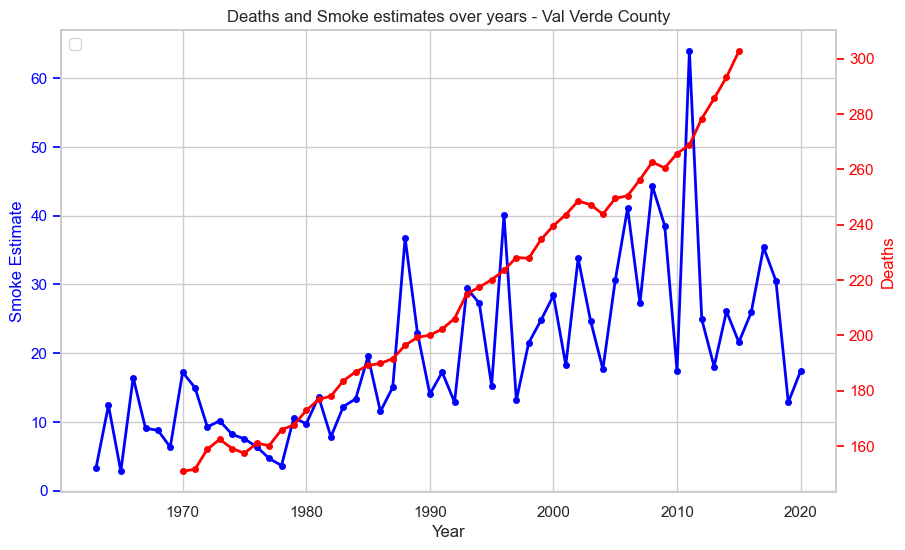

In [152]:
# Plot Smoke Estimates vs Total Deaths
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset on the first y-axis
ax1.plot(smoke_aqi['Fire_Year'], smoke_aqi['avg_smoke_estimate'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=4)
# ax1.plot(x, y1, color='blue', label='sin(x)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis
ax2.plot(deaths_race_df['Year'], deaths_race_df['All Races Total Deaths'],marker='o', color='red', linestyle='-', linewidth=2, markersize=4)
# ax2.plot(x, y2, color='red', label='cos(x)')
ax2.set_ylabel('Deaths', color='red')
ax2.tick_params('y', colors='red')

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Deaths and Smoke estimates over years - Val Verde County')
plt.grid(False)
plt.show()

# # Customize the chart
# plt.title('Deaths')
# plt.xlabel('Year')
# plt.ylabel('Deaths')
# plt.legend()  # Add a legend to distinguish the two lines

# # Display the chart
# plt.grid(True)
# plt.show()

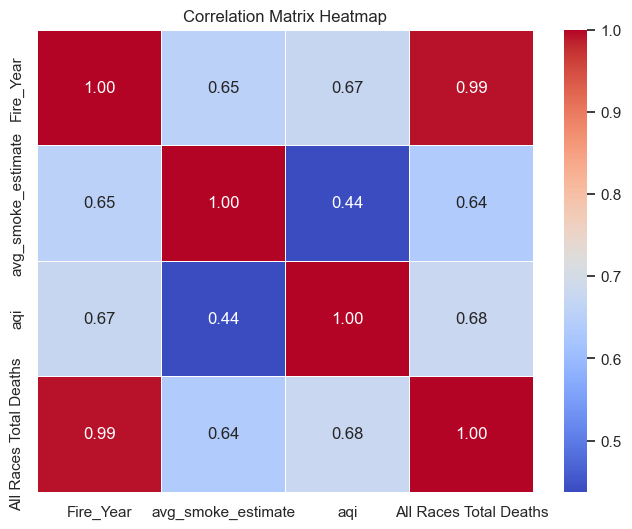

In [150]:
# Generate a correlation Matrix for the data
smoke_deaths = pd.merge(smoke_aqi,deaths_race_df,left_on="Fire_Year",right_on="Year",how="inner")
smoke_deaths_filtered = smoke_deaths[["Fire_Year","avg_smoke_estimate","aqi", "All Races Total Deaths"]]
smoke_deaths_filtered


# Calculate the correlation matrix
correlation_matrix = smoke_deaths_filtered.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# correlation_coefficient = deaths_race_df['All Races Total Deaths'].corr(smoke_aqi['avg_smoke_estimate'])
# correlation_coefficient

In [66]:
# Get Infant/Fetal Deaths data
deaths_infant_df = pd.read_excel('infant_fetal_deaths.xlsx')
# deaths_race_df['Year']=deaths_race_df['Year'].astype('float')
deaths_infant_df.head()

Year  Infant Deaths  Infant Death Rate  Fetal Deaths  Fetal Death Ratio
0  2015           2270                5.6          2172                5.4
1  2014           2320                5.8          2200                5.5
2  2013           2253                5.8          2092                5.4
3  2012           2224                5.8          2028                5.3
4  2011           2136                5.7          2087                5.5

## Smoke Estimates vs Infant and Fetal Deaths

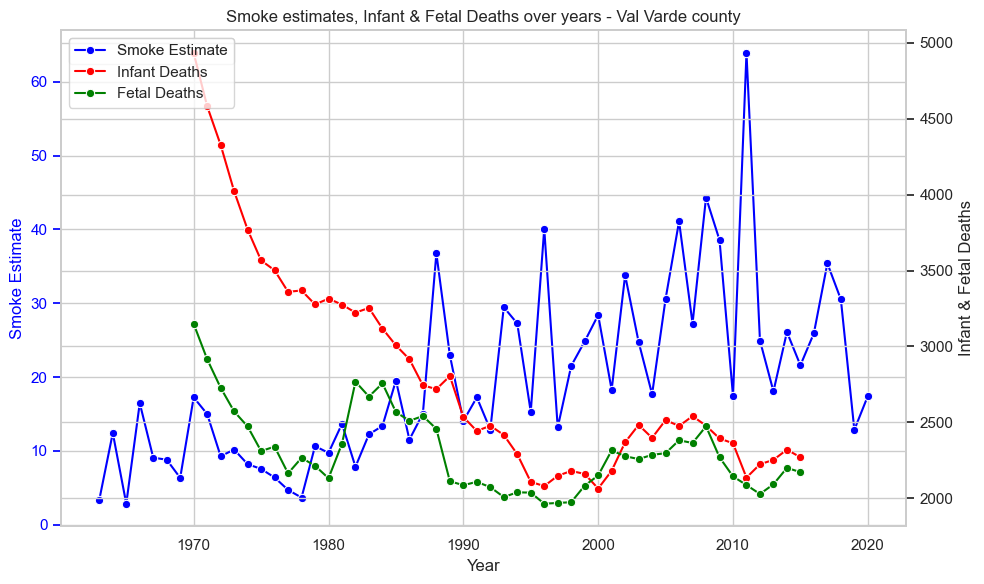

In [145]:
# Plot Smoke Estimates vs Infant and Fetal Deaths on 2 separate axes.

# Create a figure and axis with Seaborn
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset on the first y-axis using Seaborn
sns.lineplot(data=smoke_aqi, x='Fire_Year', y='avg_smoke_estimate', marker='o', color='blue', ax=ax1, label='Smoke Estimate')

ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis using Seaborn
sns.lineplot(data=deaths_infant_df, x='Year', y='Infant Deaths', marker='o', color='red', ax=ax2, label='Infant Deaths')
sns.lineplot(data=deaths_infant_df, x='Year', y='Fetal Deaths', marker='o', color='green', ax=ax2, label='Fetal Deaths')

ax2.set_ylabel('Infant & Fetal Deaths')

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Smoke estimates, Infant & Fetal Deaths over years - Val Varde county')
plt.tight_layout()  # Adjust layout
plt.show()

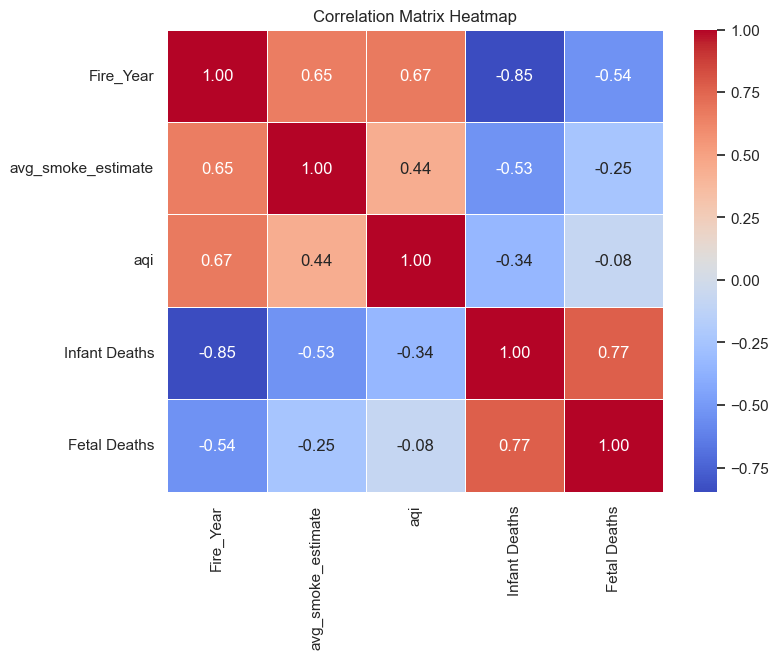

In [132]:
# Generate Correlation Matrix for the Data
smoke_infant_deaths = pd.merge(smoke_aqi,deaths_infant_df,left_on="Fire_Year",right_on="Year",how="inner")
smoke_infant_deaths_filtered = smoke_infant_deaths[["Fire_Year","avg_smoke_estimate","aqi", "Infant Deaths","Fetal Deaths"]]
smoke_infant_deaths_filtered


# Calculate the correlation matrix
correlation_matrix = smoke_infant_deaths_filtered.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# correlation_coefficient = deaths_race_df['All Races Total Deaths'].corr(smoke_aqi['avg_smoke_estimate'])
# correlation_coefficient

In [130]:
# Get Cancer deaths data
cancer_deaths_df = pd.read_excel('cancer_deaths.xlsx')
# deaths_race_df['Year']=deaths_race_df['Year'].astype('float')
cancer_deaths_df.head()

Year  Population  Cancer Deaths  Population affected  Cancer Incidents
0  1990       38562             42                  NaN               NaN
1  1991       39508             62                  NaN               NaN
2  1992       40020             68                  NaN               NaN
3  1993       40442             73                  NaN               NaN
4  1994       41348             68                  NaN               NaN

## Smoke Estimates vs Cancer Deaths and Incidence

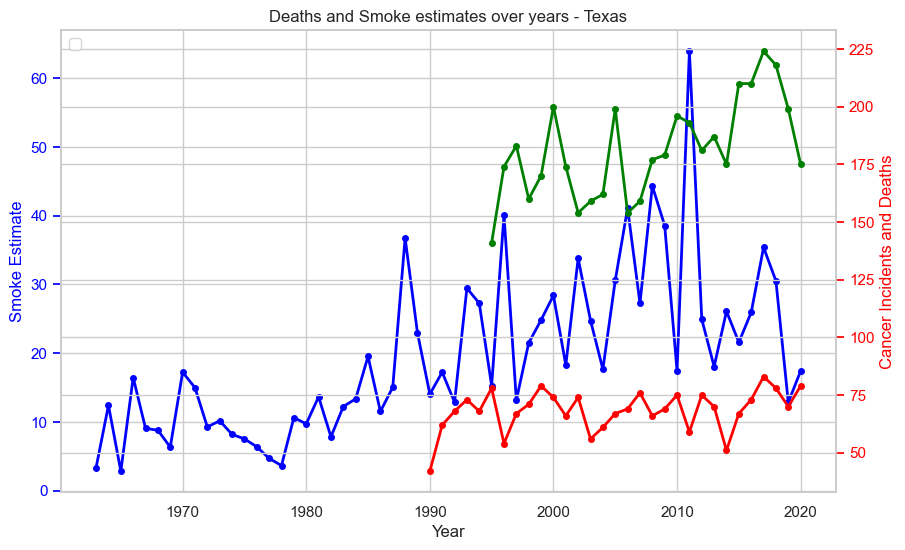

In [141]:
# Plot Smoke Estimates vs Cancer Deaths and Incidence on 2 separate axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset on the first y-axis
ax1.plot(smoke_aqi['Fire_Year'], smoke_aqi['avg_smoke_estimate'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=4)
# ax1.plot(x, y1, color='blue', label='sin(x)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Set the y-axis limits for the first axis
# ax1.set_ylim([0, 80])

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis
#ax2.plot(deaths_race_df['Year'], deaths_race_df['All Races Total Deaths'],marker='o', color='r', linestyle='-', linewidth=2, markersize=4)
ax2.plot(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Deaths'],marker='o', color='red', linestyle='-', linewidth=2, markersize=4)
ax2.plot(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Incidents'],marker='o', color='green', linestyle='-', linewidth=2, markersize=4)
#ax2.plot(deaths_infant_df['Year'], deaths_infant_df['Fetal Deaths'],marker='o', color='g', linestyle='-', linewidth=2, markersize=4)
#
# ax2.plot(x, y2, color='red', label='cos(x)')
ax2.set_ylabel('Cancer Incidents and Deaths', color='red')
ax2.tick_params('y', colors='red')

# Set the y-axis limits for the first axis
# ax2.set_ylim([20, 100])

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Deaths and Smoke estimates over years - Texas')
plt.show()

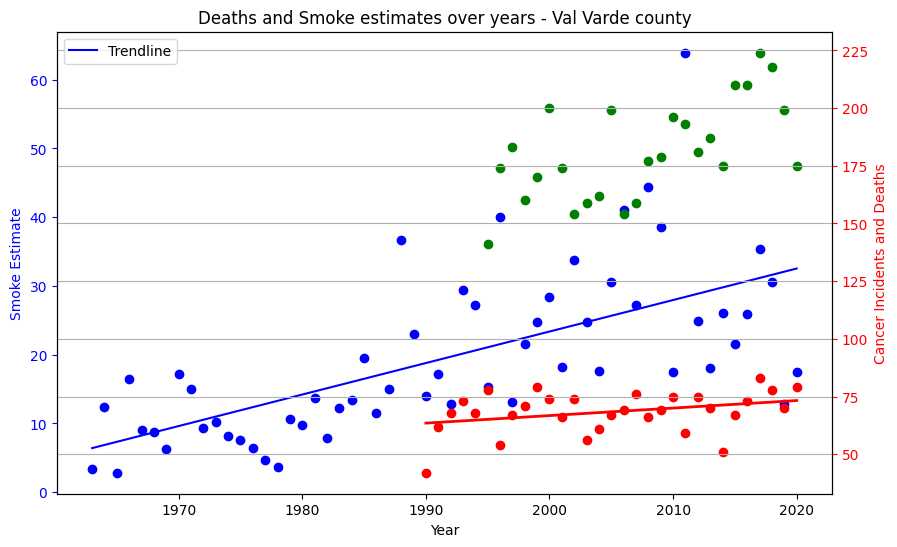

In [101]:
# Plot Smoke Estimates vs Cancer Deaths and Incidence on 2 separate axes
# TRY NEW DESIGNS TO SEE TREND
fig, ax1 = plt.subplots(figsize=(10, 6))
x=smoke_aqi['Fire_Year']
y1=smoke_aqi['avg_smoke_estimate']
coefficients = np.polyfit(x, y1, 1)
trendline = np.poly1d(coefficients)

# Plot the first dataset on the first y-axis
ax1.scatter(x, y1, color='b')
ax1.plot(x, trendline(x), linestyle='-', color='blue', label='Trendline')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Set the y-axis limits for the first axis
# ax1.set_ylim([0, 80])

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis
#ax2.plot(deaths_race_df['Year'], deaths_race_df['All Races Total Deaths'],marker='o', color='r', linestyle='-', linewidth=2, markersize=4)
coefficients = np.polyfit(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Deaths'], 1)
trendline = np.poly1d(coefficients)
ax2.scatter(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Deaths'], color='r')
ax2.plot(cancer_deaths_df['Year'], trendline(cancer_deaths_df['Year']), color='r', linestyle='-', linewidth=2, markersize=4)
coefficients = np.polyfit(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Incidents'], 1)
trendline = np.poly1d(coefficients)
ax2.scatter(cancer_deaths_df['Year'], cancer_deaths_df['Cancer Incidents'], color='g')
ax2.plot(cancer_deaths_df['Year'], trendline(cancer_deaths_df['Year']), color='g', linestyle='-', linewidth=2, markersize=4)
#ax2.plot(deaths_infant_df['Year'], deaths_infant_df['Fetal Deaths'],marker='o', color='g', linestyle='-', linewidth=2, markersize=4)
#
# ax2.plot(x, y2, color='red', label='cos(x)')
ax2.set_ylabel('Cancer Incidents and Deaths', color='red')
ax2.tick_params('y', colors='red')

# Set the y-axis limits for the first axis
# ax2.set_ylim([20, 100])

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Deaths and Smoke estimates over years - Val Varde county')
plt.grid(True)
plt.show()

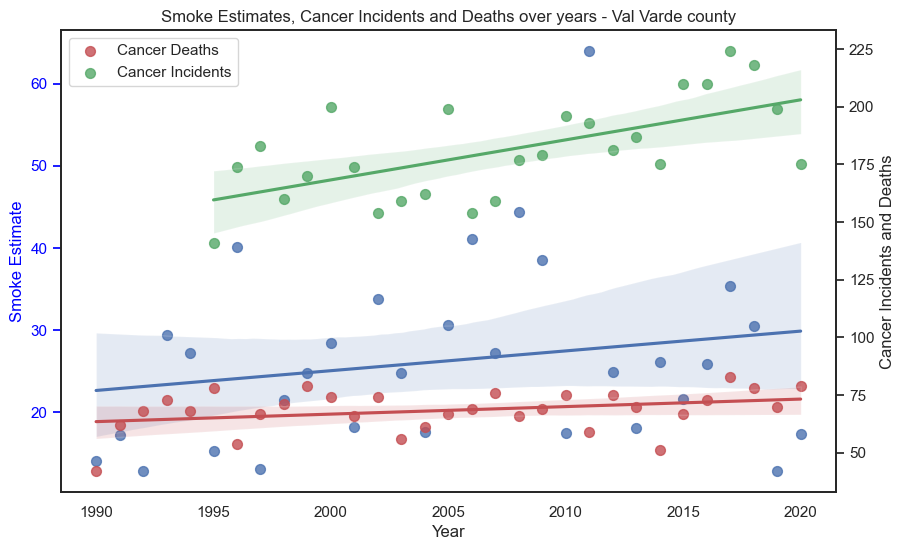

In [109]:
# Plot Smoke Estimates vs Cancer Deaths and Incidence on 2 separate axes using seaborn
# Finalizing the graph
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming smoke_aqi, cancer_deaths_df are your dataframes

# Set the style for Seaborn
sns.set(style="white")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset on the first y-axis with scatter plot and trendline
sns.regplot(x='Fire_Year', y='avg_smoke_estimate', data=smoke_aqi[smoke_aqi['Fire_Year']>=1990], ax=ax1, marker='o', color='b', scatter_kws={"s": 50})
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis with scatter plot and trendline
sns.regplot(x='Year', y='Cancer Deaths', data=cancer_deaths_df, ax=ax2, marker='o', color='r', scatter_kws={"s": 50}, label='Cancer Deaths')
sns.regplot(x='Year', y='Cancer Incidents', data=cancer_deaths_df, ax=ax2, marker='o', color='g', scatter_kws={"s": 50}, label='Cancer Incidents')

ax2.set_ylabel('Cancer Incidents and Deaths')
ax2.tick_params('y')

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Smoke Estimates, Cancer Incidents and Deaths over years - Val Varde county')
plt.show()

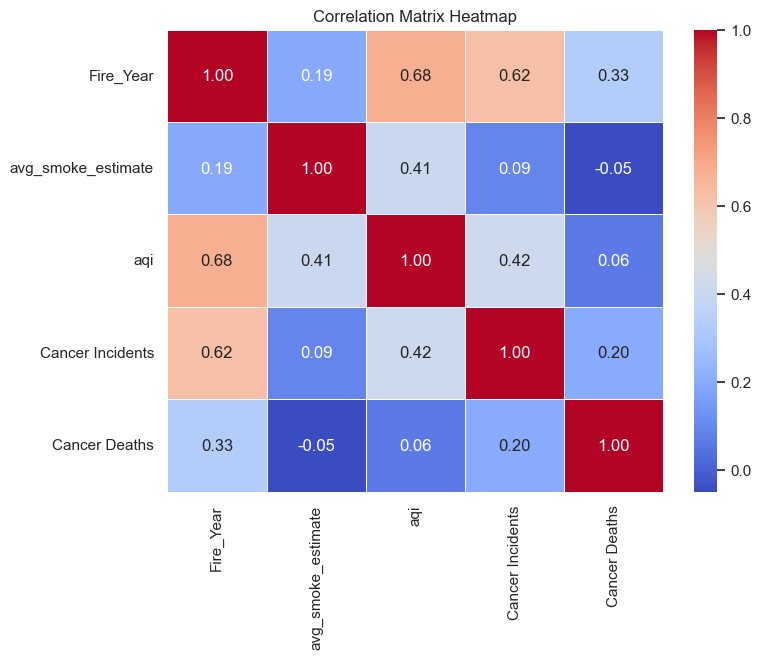

In [119]:
# Generate Correlation Matrix for the data
smoke_cancer_deaths = pd.merge(smoke_aqi,cancer_deaths_df,left_on="Fire_Year",right_on="Year",how="inner")
smoke_cancer_deaths_filtered = smoke_cancer_deaths[["Fire_Year","avg_smoke_estimate","aqi", "Cancer Incidents","Cancer Deaths"]]
smoke_cancer_deaths_filtered


# Calculate the correlation matrix
correlation_matrix = smoke_cancer_deaths_filtered.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# correlation_coefficient = deaths_race_df['All Races Total Deaths'].corr(smoke_aqi['avg_smoke_estimate'])
# correlation_coefficient

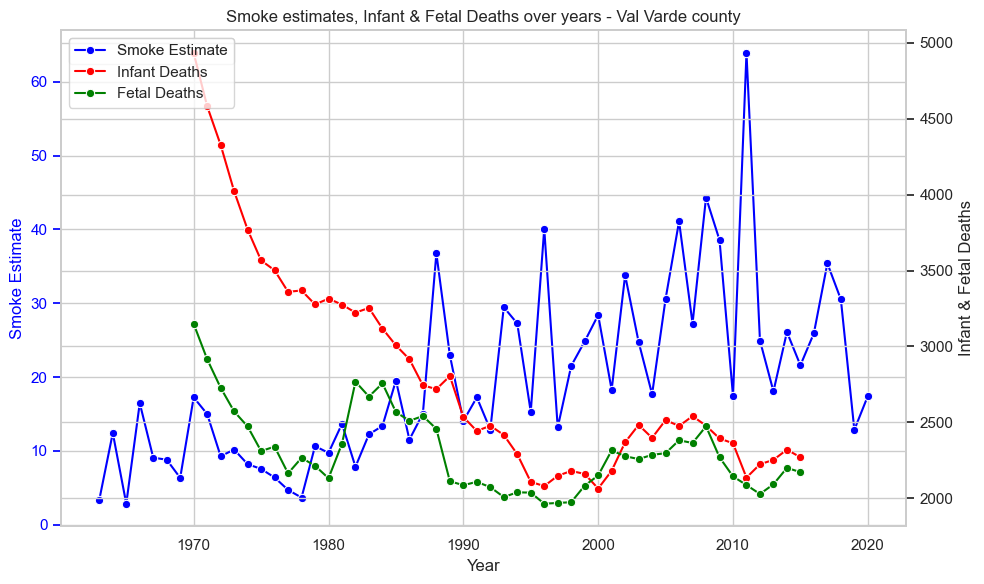

In [145]:
#sns.set(style="whitegrid")

# Create a figure and axis with Seaborn
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset on the first y-axis using Seaborn
sns.lineplot(data=smoke_aqi, x='Fire_Year', y='avg_smoke_estimate', marker='o', color='blue', ax=ax1, label='Smoke Estimate')

ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate', color='blue')
ax1.tick_params('y', colors='blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis using Seaborn
sns.lineplot(data=deaths_infant_df, x='Year', y='Infant Deaths', marker='o', color='red', ax=ax2, label='Infant Deaths')
sns.lineplot(data=deaths_infant_df, x='Year', y='Fetal Deaths', marker='o', color='green', ax=ax2, label='Fetal Deaths')

ax2.set_ylabel('Infant & Fetal Deaths')

# Add a legend for both datasets
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Smoke estimates, Infant & Fetal Deaths over years - Val Varde county')
plt.tight_layout()  # Adjust layout
plt.show()